## Simple Kalman estimator example (no control)

Sawyer B. Fuller, 2020.01.12, updated 2023.02.17 to use new lqe function in control systems library 

Boilerplate imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

Dynamics system is a damped body moving through space: $m \dot v  = -b * v + u$ 

In [2]:

m = 1
b = 1
sensor_noise_std = .1

def dynamics(q, u=0):
    v = q
    return -b/m * v + u/m

def sensor_model(q):
    v = q
    return v + np.random.randn() * sensor_noise_std

A = np.array([[-b/m]])
B = np.array(1/m)
G = np.array(1)
C = np.array([[1]])

Check observability

In [3]:
obsv = ct.obsv(A, C) 
print(np.linalg.matrix_rank(obsv)) # gives value equal to size of A => full rank => is observable

1


## A) 
construct weight matrices and kalman gain matrix for low disturbance case

In [4]:
# disturbance size
QN = .1 # tuning knob
# sensor noise
RN = sensor_noise_std**2
L = ct.lqe(A, G, C, QN, RN)[0]
print(L)

[[2.31662479]]


Simulate

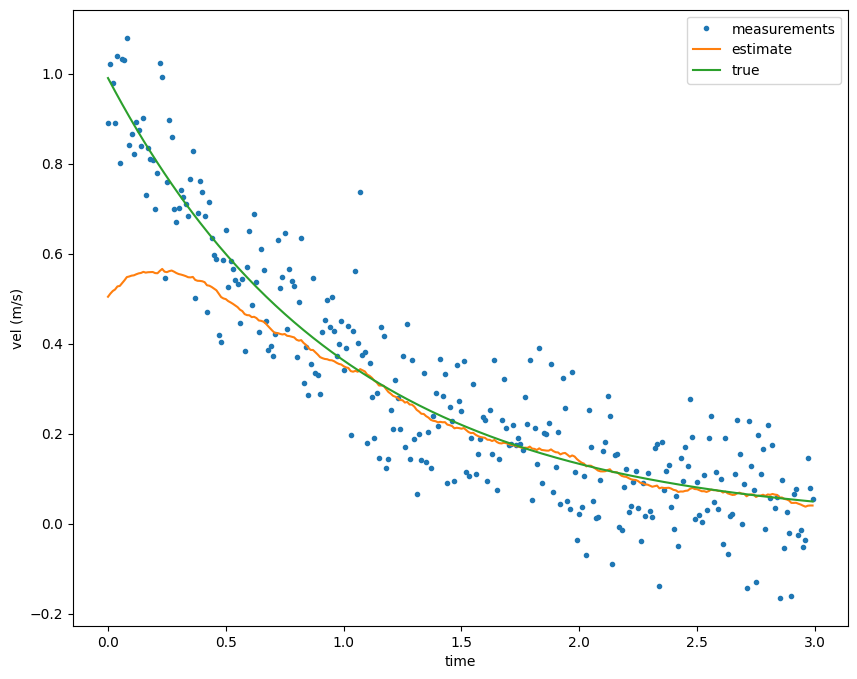

In [5]:
dt = 0.01
time = np.arange(0, 3, dt)
q = np.array((1,)) # initial condition
qhat = np.array((.5,)) # initial estimate

q_data = np.zeros((len(time), len(q))) # log of state vector
y_data = np.zeros((len(time), 1)) # log of output vector 
qhat_data = np.zeros((len(time), len(q))) # log of state estimates

for idx, t in enumerate(time):
    y = sensor_model(q)
    q = q + dt * dynamics(q)
    qhat = qhat + dt * (A @ qhat + L @ (y - C @ qhat))
    q_data[idx,:] = q
    qhat_data[idx,:] = qhat
    y_data[idx,:] = y 

if 0:
    # example for slide 
    plt.figure()
    plt.plot(time, y_data, '.', time, q_data)
    plt.xlabel('time'); plt.ylabel('vel (m/s)')
    plt.legend(('measurements', 'true'))
else:
    plt.figure(figsize=(10,8))
    plt.plot(time, y_data, '.', time, qhat_data, time, q_data)
    plt.xlabel('time'); plt.ylabel('vel (m/s)')
    plt.legend(('measurements', 'estimate', 'true'))


## B) 
now try with greater disturbance noise => greater L => depend more on sensor readings

[[9.04987562]]


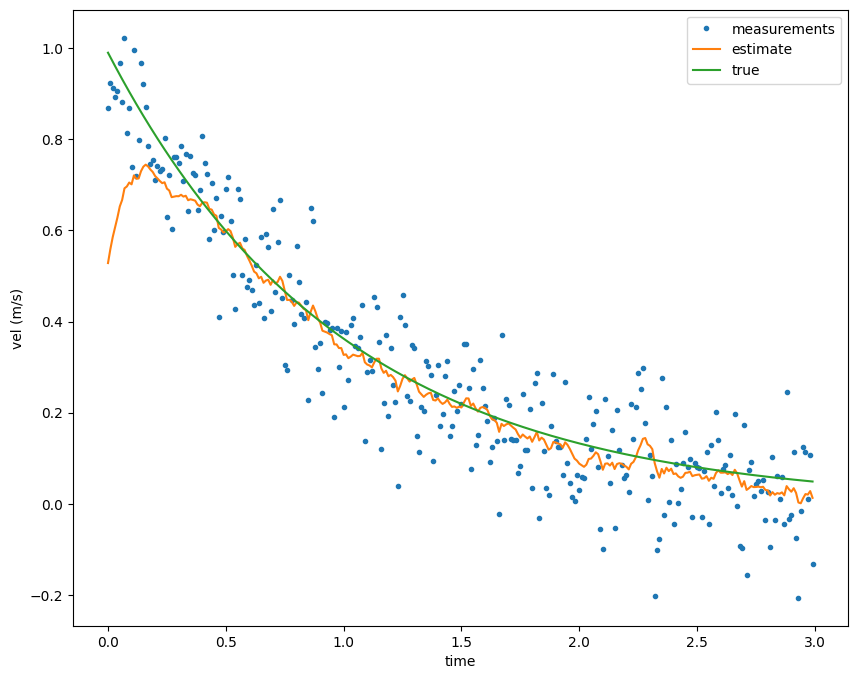

In [6]:
# disturbance size
QN = 1 # tuning knob
L = ct.lqe(A, G, C, QN, RN)[0]
print(L)

q = np.array((1,)) # initial condition
qhat = np.array((.5,)) # initial estimate
for idx, t in enumerate(time):
    y = sensor_model(q)
    q = q + dt * dynamics(q)
    qhat = qhat + dt * (A @ qhat + L @ (y - C @ qhat))
    q_data[idx,:] = q
    qhat_data[idx,:] = qhat
    y_data[idx,:] = y 
    
plt.figure(figsize=(10,8))
plt.plot(time, y_data, '.', time, qhat_data, time, q_data)
plt.xlabel('time'); plt.ylabel('vel (m/s)')
plt.legend(('measurements', 'estimate', 'true'));

Without a dynamics model, the Kalman Filter behaves something like a simple low-pass filter. Downside: significant lag. 

[[2.31662479]]


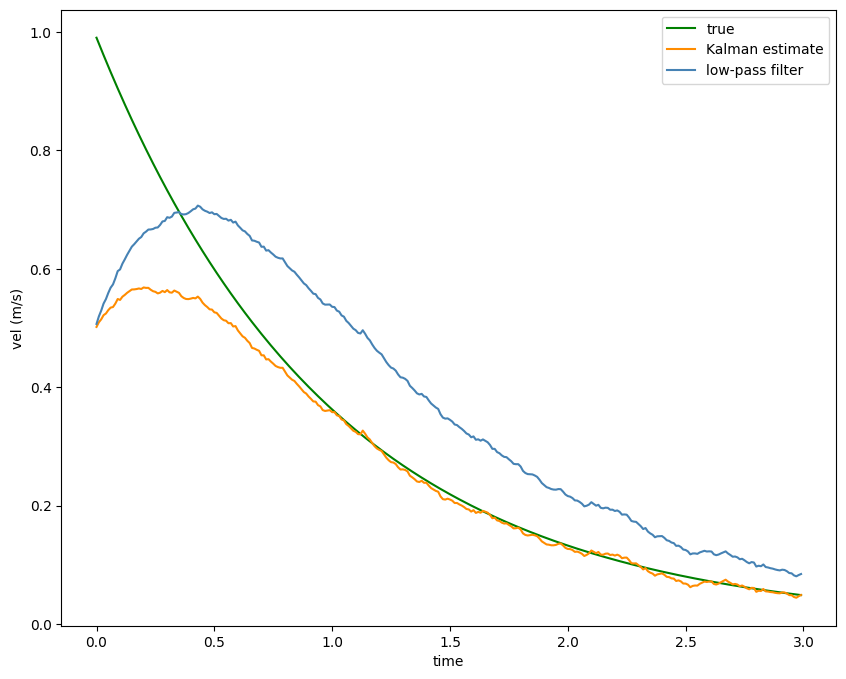

In [7]:
QN = .1 # tuning knob: decrease this => rely more on prediction than sensors
L = ct.lqe(A, G, C, QN, RN)[0]
print(L)
q = np.array((1,)) # initial condition
qhat = np.array((.5,)) # initial estimate
q_lopass = np.array((.5,))
q_lopass_data = np.zeros((len(time),1))
for idx, t in enumerate(time):
    y = sensor_model(q)
    q = q + dt * dynamics(q)
    qhat = qhat + dt * (A @ qhat + L @ (y - C @ qhat))
    q_lopass = q_lopass + dt * L @ (y - C @ q_lopass)
    q_data[idx,:] = q
    qhat_data[idx,:] = qhat
    q_lopass_data[idx,:] = q_lopass
    y_data[idx,:] = y 
    
plt.figure(figsize=(10,8))
plt.plot(time, q_data, 'green', time, qhat_data, 'darkorange', time, q_lopass_data, 'steelblue')
plt.xlabel('time'); plt.ylabel('vel (m/s)')
plt.legend(('true', 'Kalman estimate', 'low-pass filter'));

## C) 
velocity sensing with optic flow

[[9.04987562]]


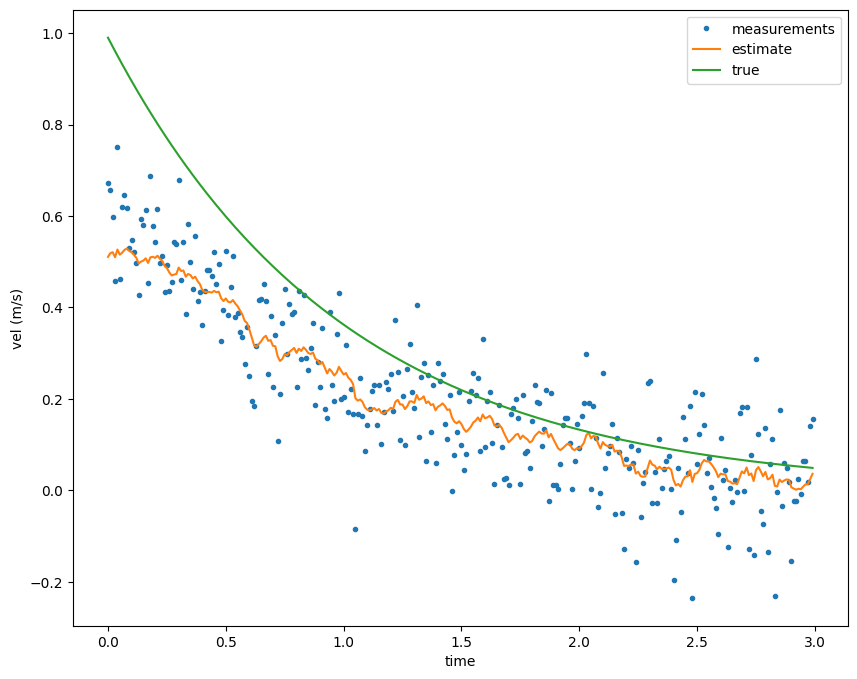

In [8]:
# disturbance size
QN = 1 # tuning knob
# new C linearized at z = z_d
z_d = 1
C = np.array(1/z_d, ndmin=2)
L = ct.lqe(A, G, C, QN, RN)[0]
print(L)

def sensor_model(q):
    v = q
    z = 1.5 # true altitude
    Omega = v/z
    return Omega + np.random.randn() * sensor_noise_std

q = np.array((1,)) # initial condition
qhat = np.array((.5,)) # initial estimate
for idx, t in enumerate(time):
    y = sensor_model(q)
    q = q + dt * dynamics(q)
    qhat = qhat + dt * (A @ qhat + L @ (y - C @ qhat))
    q_data[idx,:] = q
    qhat_data[idx,:] = qhat
    y_data[idx,:] = y 
    
plt.figure(figsize=(10,8))
plt.plot(time, y_data, '.', time, qhat_data, time, q_data)
plt.xlabel('time'); plt.ylabel('vel (m/s)')
plt.legend(('measurements', 'estimate', 'true'));